# Capstone Project VII: Unsupervised Learning
Generate an in-depth analysis of the <code>UsArrests.csv</code> dataset using unsupervised machine learning techniques.
## Set-up and inital observations
Before any analysis can take place, the necessary modules and dataset must be imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

### Import the dataset
The dataset, <code>UsArrests.csv</code>, contains arrests per 100,000 residents for a variety of crimes in each of the 50 US states. It also gives the urban population of a state as a percentage of the total population. This dataset is from 1973.  

In [2]:
# Add short form of state names to DF
short_names = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
    'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
    'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
    'VA', 'WA', 'WV', 'WI', 'WY'
]

In [3]:
df = pd.read_csv('UsArrests.csv')
# rename 'City' to 'State'
df = df.rename(columns={'City': 'State'})
df['Initial'] = short_names
# reorder columns so urban pop is at the end
df = df[['Initial', 'State', 'Murder', 'Assault', 'Rape', 'UrbanPop']]
df.head()

,Initial,State,Murder,Assault,Rape,UrbanPop
0,AL,Alabama,13.2,236,21.2,58
1,AK,Alaska,10.0,263,44.5,48
2,AZ,Arizona,8.1,294,31.0,80
3,AR,Arkansas,8.8,190,19.5,50
4,CA,California,9.0,276,40.6,91


### Examine the dataset
After the dataset is loaded, examine the dataframe for missing values and other insights.

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0


From above, there are no missing values in the dataset (count = 50 for each column). However, the values for 'Assault' are significantly larger than the values in other columns. Therefore, it will be necessary to scale the data so that all columns will contribute to the analysis equally.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Initial   50 non-null     object 
 1   State     50 non-null     object 
 2   Murder    50 non-null     float64
 3   Assault   50 non-null     int64  
 4   Rape      50 non-null     float64
 5   UrbanPop  50 non-null     int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 2.5+ KB


Values for Murder and Rape are floats and values for Assault are integers. These values are to three significant figures (Assault is much larger as seen before). Urban population values are also integers and measured as percentages.  

### Distribution of variables
Plot histograms for each of the numerical variables. First plot the histograms for crimes:

Text(0.5, 0.98, 'Histrograms for crimes')

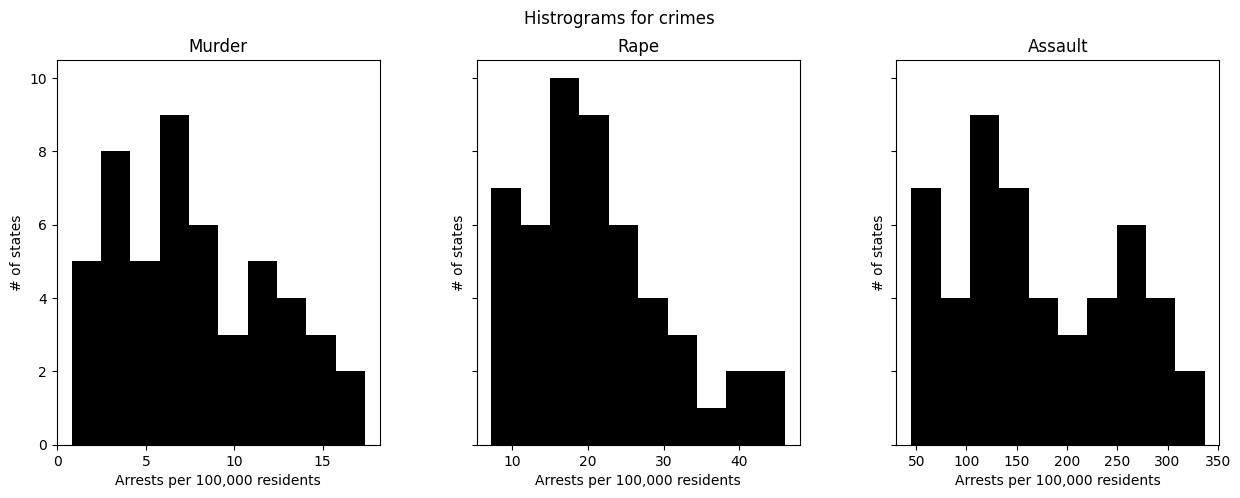

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
df.hist(grid=False, bins=10, color='black', column=['Murder', 'Rape', 'Assault'], ax=axs)
for i in range(3):
    axs[i].set_xlabel('Arrests per 100,000 residents')
    axs[i].set_ylabel('# of states')
fig.suptitle('Histrograms for crimes')

The histograms for each crime are relatively similar. Each histrogram can be described as slightly right skewed, but relatively normal (medians and means being fairly equal). However, Assault is more evenly distributed with three peaks. Murder is the least common crime while Assault is the most common.

Text(0, 0.5, '# of states')

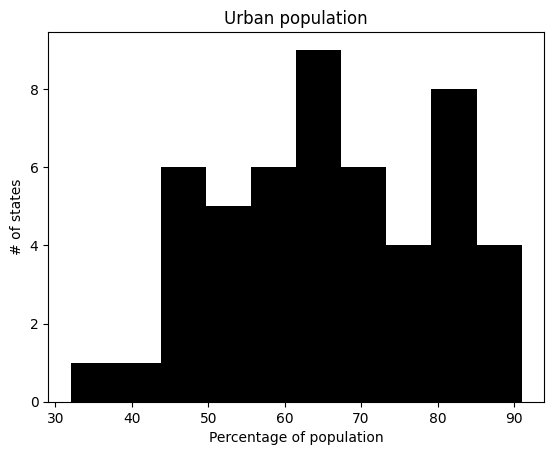

In [7]:
df.hist(column='UrbanPop', grid=False, color='black')
plt.title('Urban population')
plt.xlabel('Percentage of population')
plt.ylabel('# of states')

Urban population percentage is also fairly normal and is centred around 66%. There is also a smaller secondary peak at around 85%. This suggests that most US states are urbanised with only a few states having less than 50% of the population living in towns and cities.
### Examine the correlations
It seems likely that the rate for individual crimes would be correlated. It is normal to talk about a crime rate in general rather than crime rates for each type of offence. Use a heatmap to visualise the correlation between variables.

In [8]:
# Mask to only display one half
mask = np.triu(np.ones_like(df.corr(numeric_only=True)))

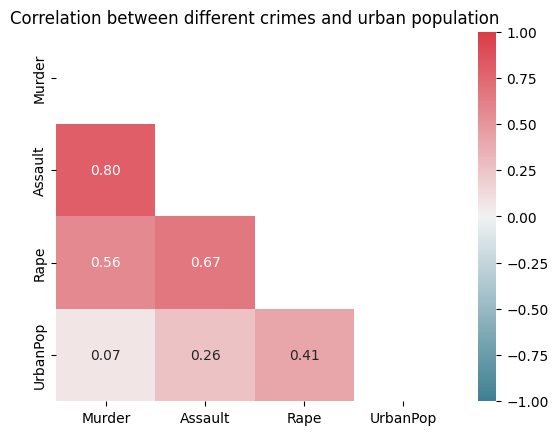

In [9]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
coef_heatmap = sns.heatmap(df.corr(numeric_only=True),
                           mask=mask,
                           annot=True,
                           vmin=-1,
                            vmax=1,
                           fmt='.2f',
                          cmap=colormap).set(title='Correlation between different crimes and urban population')

As suspected, the rates for different crimes are correlated. There is a strong positive correlation between Assault and Murder (0.80). There are also slightly weaker, but still relevant, correlations between Assault and Rape (0.67), and Murder and Rape (0.56). Urban population shows some correlation with Assault and with Rape, but is not really correlated with Murder. It may be possible to decorrelate the variables and simplify the data by applying Principal Component Analysis (PCA).

## Principal Component Analysis
Use PCA to determine the principal components that most affect the variation in the data. Depending on the influence of each principal component it may be possible to reduce the dimension of the dataset from four to tree or even two.
### Preprocessing
As seen before, Assault is on a much larger scale than the other variables. This will cause it to have a bigger influence on the analysis. Therefore, use the standard scaler to scale all the data. This will reduce the means to zero and the standard deviations to one.

In [10]:
X = df.drop(['State', 'Initial'], axis=1)
# save the labels in new variables
state_names = df['State']
X = X.values

Apply the standard scaler:

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Fit the PCA
Now that the data has been scaled, instanciate a PCA model to fit and transform the scaled data:

In [12]:
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

Check the correlations between the principal components:

In [13]:
pca_df = pd.DataFrame(principal_components)
# label columns for easy access
pca_df.columns = ['PC0', 'PC1', 'PC2', 'PC3']

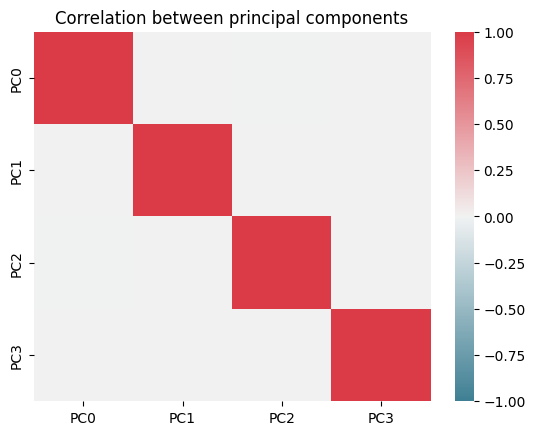

In [14]:
coef_heatmap = sns.heatmap(pca_df.corr(numeric_only=True),
                           vmin=-1,
                            vmax=1,
                          cmap=colormap).set(title='Correlation between principal components')

The heatmap shows that PCA has been successful and none of the principal components are correlated with each other.
### Principal components' influence
Examine which of the principal components have the biggest variance. These components will have the most influence on where the data points lie.

Text(0.5, 1.0, 'Variance by principal component')

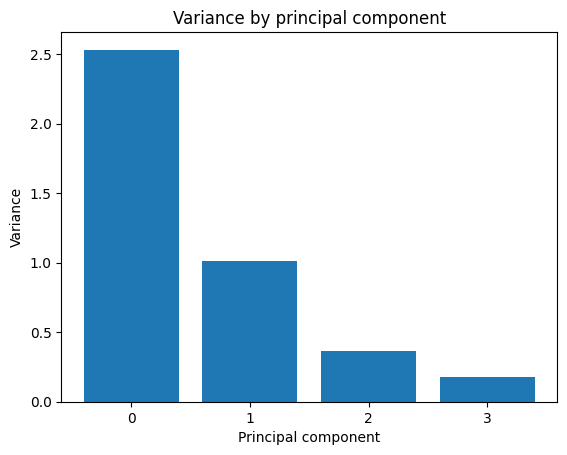

In [15]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('Principal component')
plt.title('Variance by principal component')

The bar chart shows that PC 0 accounts for most of the variance. PC 1 also explains some of the variance. PCs 2 and 3 are not so useful. Most of the variance can be explained by PCs 0 and 1.

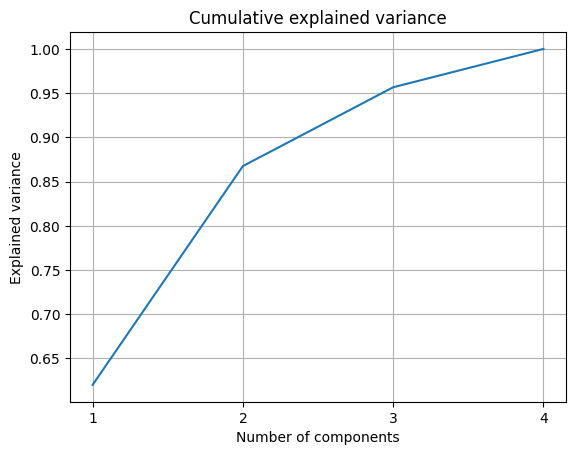

In [16]:
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1,len(pca.explained_variance_ratio_ )+1))
plt.title('Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid()

The line chart shows the amount of variance that can be explained by number of components included. Two components can explain around 86% of the variance, but included the third can increase it to over 95%. There may be a case for using three components.
### Feature importance for components

In [17]:
summary_df = pd.DataFrame()
pc_0 = pca.components_[0]
pc_1 = pca.components_[1]
pc_2 = pca.components_[2]
# column 0 and 1 are for names:
variables = df.columns[2:]

summary_df['Variable'] = variables
summary_df['PC0'] = pc_0
summary_df['PC1'] = pc_1
summary_df['PC2'] = pc_2
summary_df

,Variable,PC0,PC1,PC2
0,Murder,0.535899,0.418181,-0.341233
1,Assault,0.583184,0.187986,-0.268148
2,Rape,0.543432,-0.167319,0.817778
3,UrbanPop,0.278191,-0.872806,-0.378016


The magnitude and direction of each of the composite parts are shown in the dataframe.

PC0 gives about equal importance to Murder, Assault and Rape, but lower importance to urban population. PC1, on the other hand, gives most importance to urban population. Slightly less importance is given to Murder, and the remaining variables have less importance. PC2 mainly differs from the other two components by giving more weight to Rape arrests. Including PC2 might explain more data, but it can also complicate the analysis. It is unlikely to make much difference (<0.5, barchart), so I will continue with just two variables.

PCA has reduced the dimensions of the dataset from four to two without losing a lot of data in the process. Plot PC1 vs. PC0 to see the data in two dimensions:

In [18]:
xs = pca_df['PC0']
ys = pca_df['PC1']

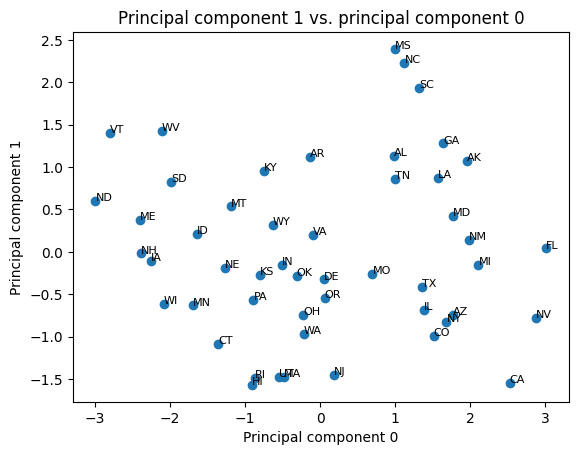

In [19]:
plt.scatter(xs, ys)
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 1')
plt.title('Principal component 1 vs. principal component 0')
for i in range(len(short_names)):
    x_coord = xs[i]
    y_coord = ys[i]
    short_name = short_names[i]
    plt.annotate(short_name, (x_coord, y_coord), fontsize=8)

This distribution of states looks logical. States that are geographically close tend to be close in the scatter plot (e.g. North Dakota and South Dakota).

## K-means clustering
The data points are now plotted in two dimensions. Cluster the points using K-Means clustering and see how each cluster compares.
### Dataframe
Select the two important components from the pca dataframe. Reducing from four dimension to two will simplify the data, reducing noise and preventing overfitting:

In [20]:
cluster_df = pca_df.drop(['PC2', 'PC3'], axis=1)
cluster_df.head()

,PC0,PC1
0,0.985566,1.133392
1,1.950138,1.073213
2,1.763164,-0.745957
3,-0.141420,1.119797
4,2.523980,-1.542934


### Find the best number of clusters
Find a value for number of clusters that minimises inertia while also minimising the number of clusters. Plot inertia against number of clusters.

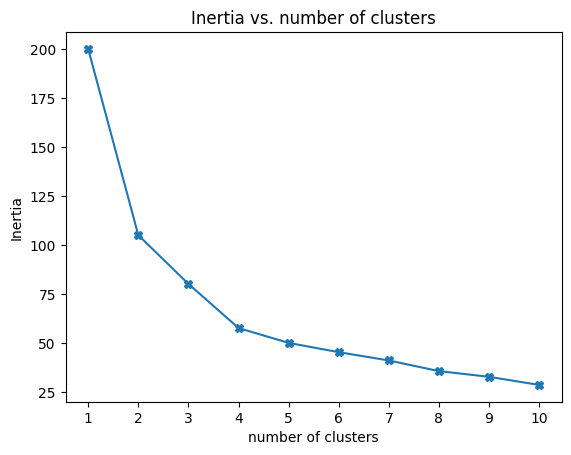

In [21]:
ks = range(1,11)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, n_init=10, random_state=1)
    model.fit(pca_df)
    inertias.append(model.inertia_)
plt.plot(ks, inertias, '-X')
plt.title('Inertia vs. number of clusters')
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

From the graph, the 'elbow', the point where inertia goes down slower, is at four. Use four clusters for the KMeans model. <br>Instanciate and fit the model to the data:

In [22]:
K_model = KMeans(n_clusters=4, n_init=10, random_state=1)
K_model.fit(cluster_df)
K_clusters = K_model.predict(cluster_df)

Calculate the silhouette score for these clusters:

In [23]:
s_score_1 = round(silhouette_score(cluster_df, K_clusters), 2)

Finally, plot these points on a scatter plot. Each point will be coloured according to how the model categorised them.

In [24]:
xs = cluster_df['PC0']
ys = cluster_df['PC1']

Text(0, 0.5, 'PC1')

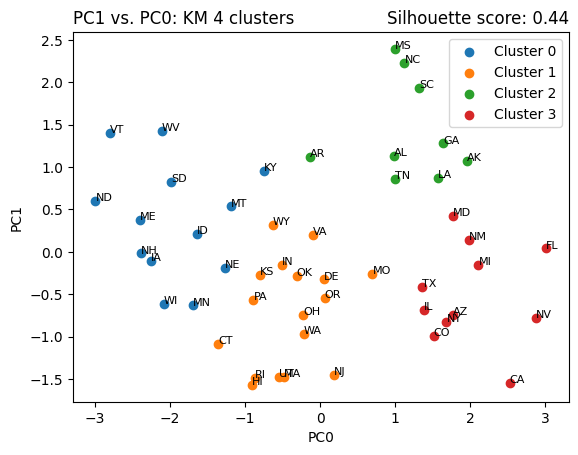

In [25]:
for cluster in range(4):
    plt.scatter(xs[K_clusters == cluster], ys[K_clusters == cluster], label = 'Cluster {}'.format(cluster))
plt.legend()
for i in range(len(short_names)):
    x_coord = xs[i]
    y_coord = ys[i]
    short_name = short_names[i]
    plt.annotate(short_name, (x_coord, y_coord), fontsize=8)
plt.title('PC1 vs. PC0: KM 4 clusters', loc='left')
plt.title('Silhouette score: ' + str(s_score_1), loc='right')
plt.xlabel('PC0')
plt.ylabel('PC1')

The scatter graph with the clusters is shown above. The silhouette score (0.44) is quite good, suggesting that the clusters are fairly consistent. Some points on the edges of clusters could potentially be classified differently (such as AR).
<p>
The model has divided the points into four clusters, but it is still not clear why it has chosen these clusters. As seen earlier, PC0 is associated with crime rates and PC1 is associated with urban population, but more analysis is required.

#### Analysis
First, add the cluster for each state to the original dataframe:

In [26]:
df['Kcluster'] = K_clusters

Now it is possible to group the original data by clusters and examine the differences between each cluster. First examine the crime rates in each cluster:

In [27]:
# Melt the df to see crime rates in one column
df_crimes = df.drop('UrbanPop', axis=1)
df_melted = df_crimes.melt(id_vars=['Initial', 'State', 'Kcluster'], var_name=["Crime"])

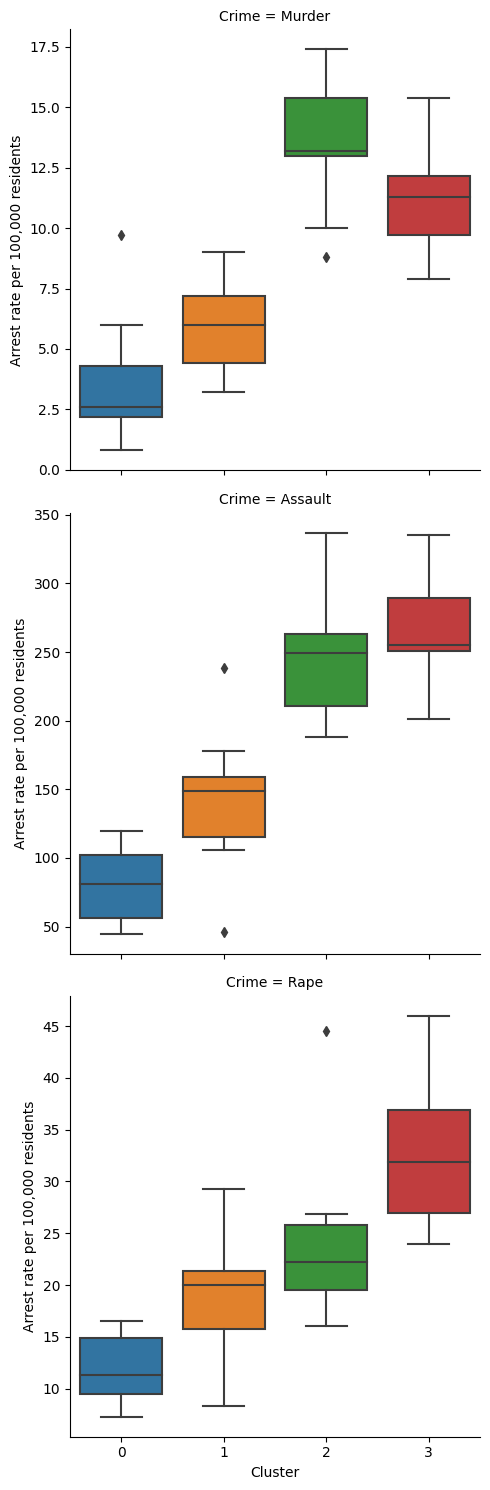

In [28]:
sns.catplot(
    data=df_melted, x='Kcluster', y='value',
    col='Crime', kind='box', col_wrap=1, sharey=False).set(xlabel='Cluster',
                                                          ylabel='Arrest rate per 100,000 residents')

From the above box plots, we can see that generally speaking, the arrest rate is higher in Cluster 2 and Cluster 3 states than in Cluster 0 and Cluster 1 states. Cluster 0 states consistently have the lowest rate for crime. States in Cluster 2 and 3 have the highest crime.
<p>
Next, examine clusters and urban population:

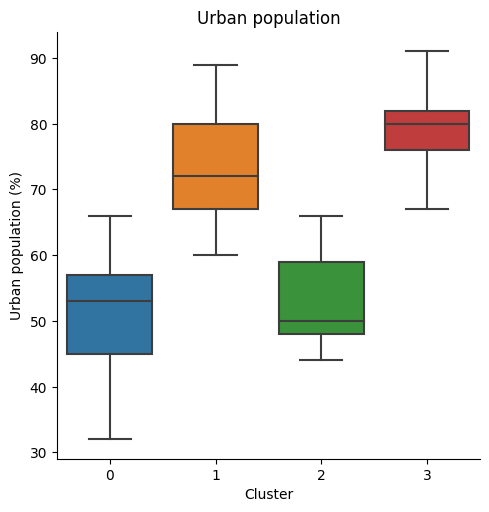

In [29]:
sns.catplot(kind='box',
            data=df,
            x='Kcluster',
            y='UrbanPop').set(title='Urban population',
                             ylabel='Urban population (%)',
                             xlabel='Cluster')

From the boxplot, we can see more similarities between the clusters. States in Cluster 0 and Cluster 2 have a similar percentage of urban population. This is also true for states in  Cluster 1 and Cluster 3.

#### Conclusions
It appears that the clusters can be classified in the following way:
<ul>
    <li><b>Cluster 0</b>: rural, low crime</li>
    <li><b>Cluster 1</b>: urban, low crime</li>
    <li><b>Cluster 2</b>: rural, high crime</li>
    <li><b>Cluster 3</b>: urban, high crime</li>
</ul>
In this case, 'rural' refers to a larger percentage of the population living outside major towns and cities.
<p>
These clusters appear to explain the data quite well. Looking at the boxplot for Murder, we see that states in Cluster 2 (rural, high crime) have the highest arrest rates. Moving to the Assault boxplot, we see that the difference in arrest rates between Cluster 2 and Cluster 1 (urban, low crime) is smaller, and Cluster 3 (urban, high crime) has the highest arrest rate. Finally, looking at the boxplot for Rape, we see that Cluster 1 is about equal with Cluster 2 and Cluster 3 is significantly higher. This is consistent with the correlation heatmap earlier that showed urban population is correlated with Assault and Rape but not Murder. This also explains why crime is consistently low for Cluster 0 (rural).

#### Location of each cluster
Take a cursory look at the geographical distribution of each cluster.
##### Cluster 0

In [30]:
df[df['Kcluster']==0]

,Initial,State,Murder,Assault,Rape,UrbanPop,Kcluster
11,ID,Idaho,2.6,120,14.2,54,0
14,IA,Iowa,2.2,56,11.3,57,0
16,KY,Kentucky,9.7,109,16.3,52,0
18,ME,Maine,2.1,83,7.8,51,0
22,MN,Minnesota,2.7,72,14.9,66,0
25,MT,Montana,6.0,109,16.4,53,0
26,NE,Nebraska,4.3,102,16.5,62,0
28,NH,New Hampshire,2.1,57,9.5,56,0
33,ND,North Dakota,0.8,45,7.3,44,0
40,SD,South Dakota,3.8,86,12.8,45,0


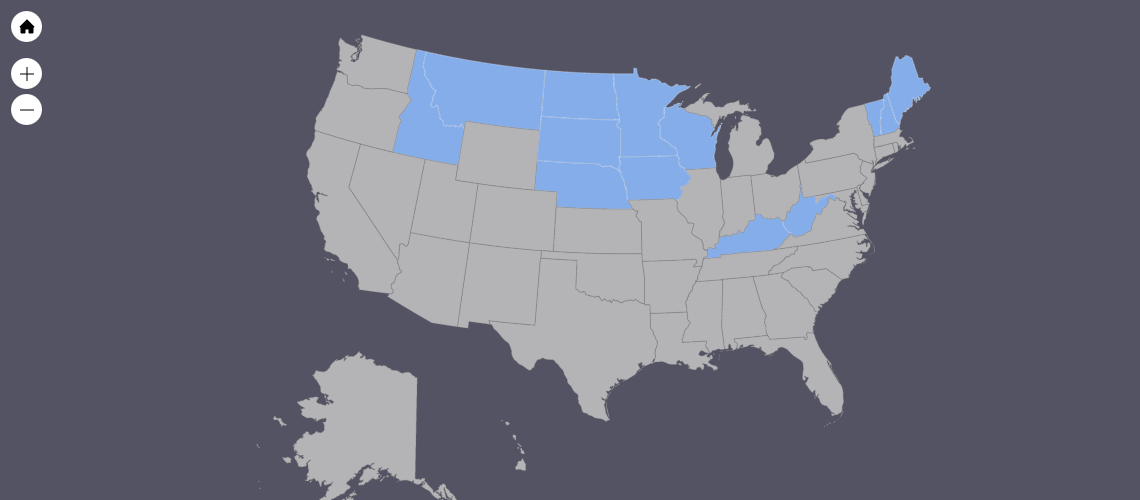
<br>
The majority of Cluster 0 states are in the North of the Midwest and Northern New England. Kentucky and West Virginia are exceptions.
##### Cluster 1

In [31]:
df[df['Kcluster']==1]

,Initial,State,Murder,Assault,Rape,UrbanPop,Kcluster
6,CT,Connecticut,3.3,110,11.1,77,1
7,DE,Delaware,5.9,238,15.8,72,1
10,HI,Hawaii,5.3,46,20.2,83,1
13,IN,Indiana,7.2,113,21.0,65,1
15,KS,Kansas,6.0,115,18.0,66,1
20,MA,Massachusetts,4.4,149,16.3,85,1
24,MO,Missouri,9.0,178,28.2,70,1
29,NJ,New Jersey,7.4,159,18.8,89,1
34,OH,Ohio,7.3,120,21.4,75,1
35,OK,Oklahoma,6.6,151,20.0,68,1


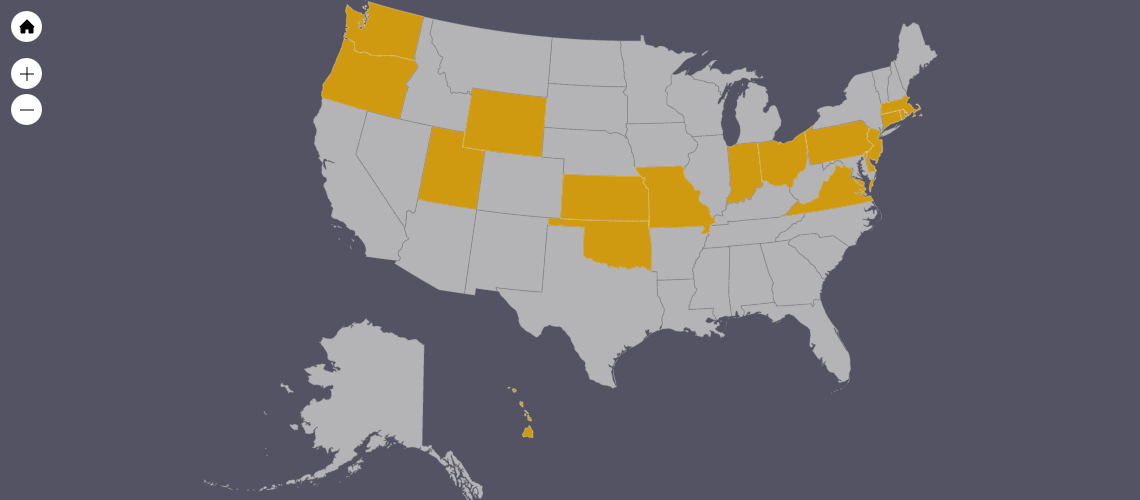
<br>
Cluster 1 states are more distributed across the USA. Many are found on the North part of the East Coast.
##### Cluster 2

In [32]:
df[df['Kcluster']==2]

,Initial,State,Murder,Assault,Rape,UrbanPop,Kcluster
0,AL,Alabama,13.2,236,21.2,58,2
1,AK,Alaska,10.0,263,44.5,48,2
3,AR,Arkansas,8.8,190,19.5,50,2
9,GA,Georgia,17.4,211,25.8,60,2
17,LA,Louisiana,15.4,249,22.2,66,2
23,MS,Mississippi,16.1,259,17.1,44,2
32,NC,North Carolina,13.0,337,16.1,45,2
39,SC,South Carolina,14.4,279,22.5,48,2
41,TN,Tennessee,13.2,188,26.9,59,2


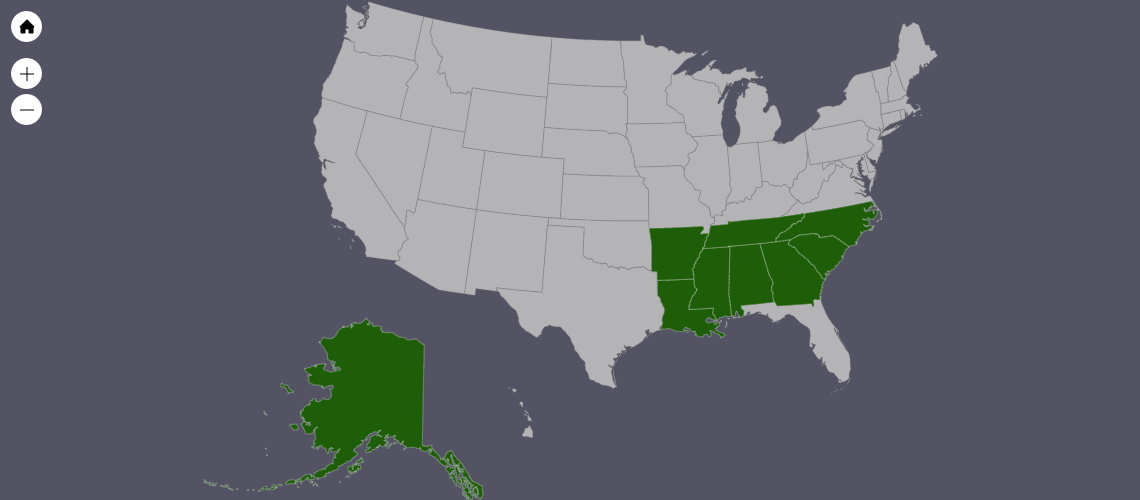
<br>
Cluster 2 states align perfectly with the Deep South. It also includes Alaska.
##### Cluster 3

In [33]:
df[df['Kcluster']==3]

,Initial,State,Murder,Assault,Rape,UrbanPop,Kcluster
2,AZ,Arizona,8.1,294,31.0,80,3
4,CA,California,9.0,276,40.6,91,3
5,CO,Colorado,7.9,204,38.7,78,3
8,FL,Florida,15.4,335,31.9,80,3
12,IL,Illinois,10.4,249,24.0,83,3
19,MD,Maryland,11.3,300,27.8,67,3
21,MI,Michigan,12.1,255,35.1,74,3
27,NV,Nevada,12.2,252,46.0,81,3
30,NM,New Mexico,11.4,285,32.1,70,3
31,NY,New York,11.1,254,26.1,86,3


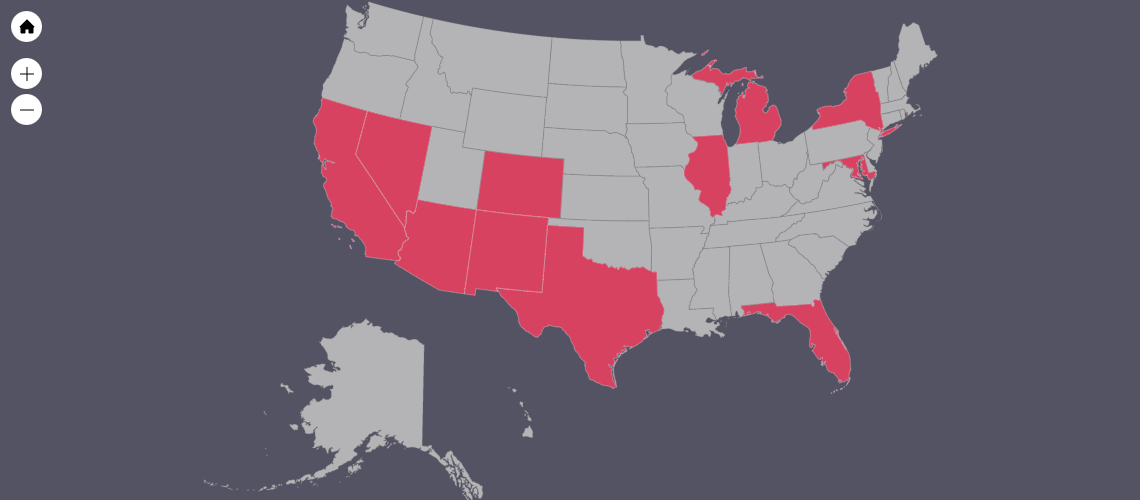
<br>
Cluster 3 states are found mainly in the South West and Texas. They are also found around the Great Lakes in the North East and Florida. 

## Hierarchical clustering
While KMeans clustering can give insights into a dataset, it is not robust and can be affected by noise in the data. Before accepting the conclusions found earlier, it is necessary to validate the clusters with a different algorithm. 

In [34]:
methods = ['single', 'average', 'complete']
links = []
for method in methods:
    mergings = linkage(cluster_df, method=method, metric='Euclidean')
    links.append(mergings)

Using Euclidean distance, create three dendrogram, each using a different method for connecting. The method that produces the most balanced dendrogram will be used for the agglomerative clustering model:

Text(0.5, 1.0, 'Complete')

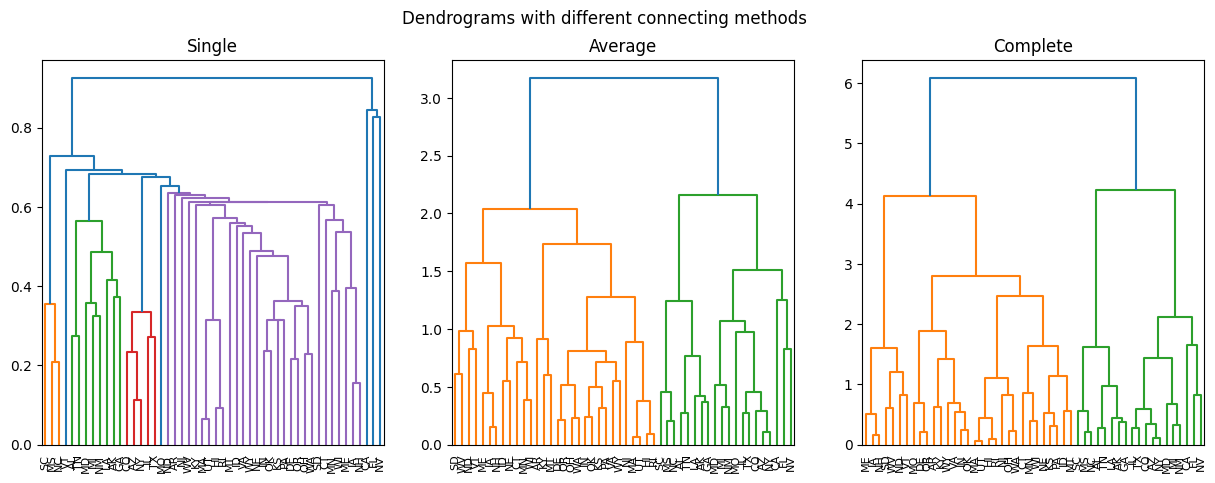

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    dendrogram(links[i], labels=short_names, ax=axs[i])
plt.suptitle('Dendrograms with different connecting methods')
axs[0].set_title('Single')
axs[1].set_title('Average')
axs[2].set_title('Complete')

Using the average method seems to give the most balanced dendrogram. This dendrogram is shown with more detail below:

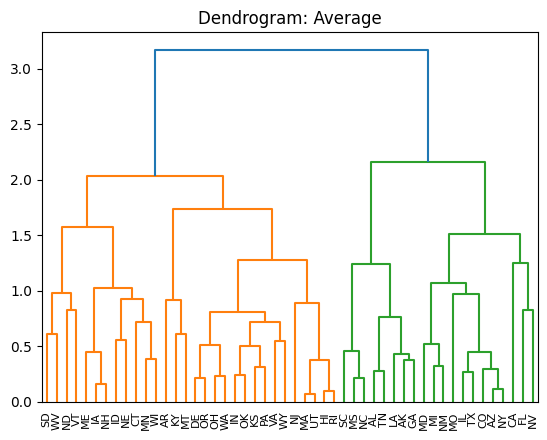

In [37]:
dendrogram(links[1], labels=short_names)
plt.title('Dendrogram: Average')
plt.show()

This dendrogram produces two main cluster. The first contains 30 states and the second contains 20. Use agglomerative clustering with 2 clusters:

In [38]:
agg_2_model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='average')
agg_2 = agg_2_model.fit_predict(cluster_df)

Calculate the silhouette score and plot the clusters:

In [39]:
s_score_2 = round(silhouette_score(cluster_df, agg_2_model.labels_), 2)

Text(0, 0.5, 'PC1')

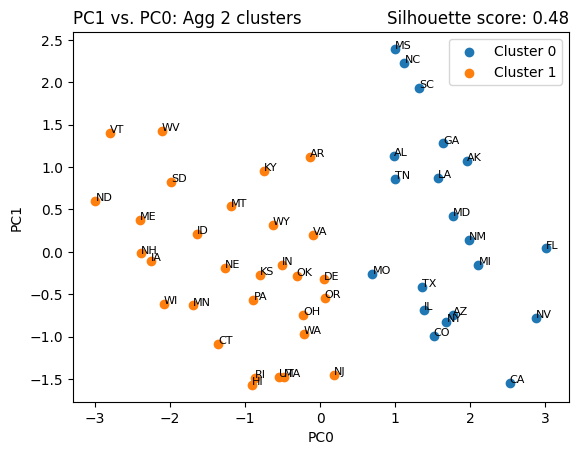

In [40]:
for cluster in range(2):
    plt.scatter(xs[agg_2 == cluster], ys[agg_2 == cluster], label = 'Cluster {}'.format(cluster))
plt.legend()
for i in range(len(short_names)):
    x_coord = xs[i]
    y_coord = ys[i]
    short_name = short_names[i]
    plt.annotate(short_name, (x_coord, y_coord), fontsize=8)
plt.title('PC1 vs. PC0: Agg 2 clusters', loc='left')
plt.title('Silhouette score: ' + str(s_score_2), loc='right')
plt.xlabel('PC0')
plt.ylabel('PC1')

The data points have been divided into 2 clusters. What cluster a datapoint is in is mostly determined by its position on the PC0 axis. This is consistent with the variance bar chart earlier that showed that PC0 accounted for most variation. The silhouette for these clusters is higher suggesting that these clusters are slightly more cohesive than the KMeans clusters.
### Comparision to previous clusters
How do these clusters correspond to the clusters found with KMeans?

In [41]:
# Add to Df
df['Agg_2'] = agg_2

Cross tabulate the clusters:

In [43]:
pd.crosstab(df['Agg_2'], df['Kcluster'])

Kcluster,0,1,2,3
Agg_2,,,,
0,0,1,8,11
1,13,16,1,0


<ul>
    <li>
        Agglomerative Cluster 0 corresponds to the Kmeans Cluster 2 and Cluster 3 (19/20).
    </li>
    <li>
        Agglomerative Cluster 1 corresponds to Kmeans Cluster 0 and Cluster 1 (29/30).
    </li>
</ul>
Therefore, Cluster 0 contains states with high crime rates and Cluster 1 contains states with low crime rates. Urban population is not fully captured by this model.
<p>
Two states have been classified differently in this model, Missouri (low to high crime) and Arkansas (high to low crime). These states are at the border between clusters, so they fit relatively well in either one.

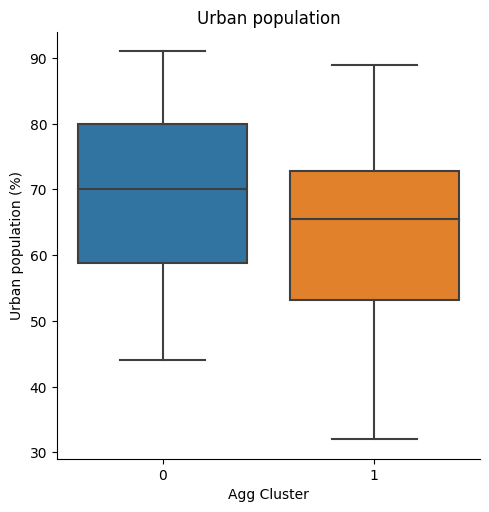

In [45]:
sns.catplot(kind='box',
            data=df,
            x='Agg_2',
            y='UrbanPop').set(title='Urban population',
                             ylabel='Urban population (%)',
                             xlabel='Agg Cluster')

The above plot shows that urban population does not vary much across the clusters. There is significant overlap and their medians are almost equal. Comparing the arrest rates:

In [46]:
df_crimes_2 = df.drop(['UrbanPop', 'Kcluster'], axis=1)
df_melted_2 = df_crimes_2.melt(id_vars=['Initial', 'State', 'Agg_2'], var_name=['Crime'])

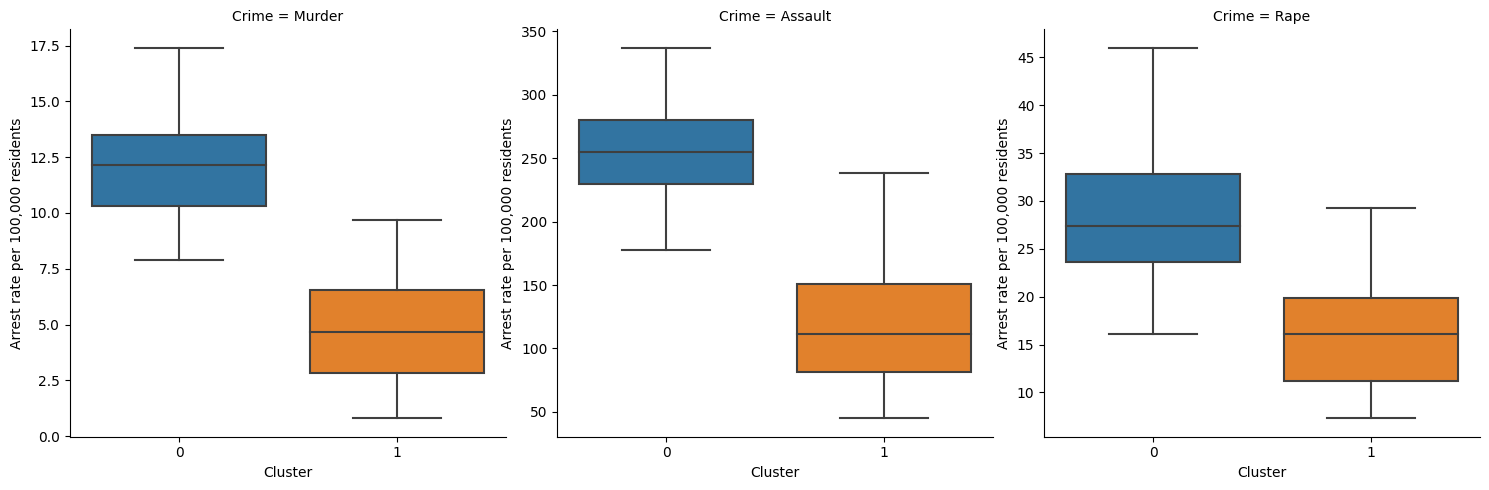

In [47]:
 sns.catplot(
    data=df_melted_2, x='Agg_2', y='value',
    col='Crime', kind='box', col_wrap=3, sharey=False).set(xlabel='Cluster',
                                                          ylabel='Arrest rate per 100,000 residents')

The above boxplots show a clear pattern in the arrest rate for each offence. In each case, states in Cluster 0 have a higher arrest rate. This difference is clearest for Murder arrests. This difference decreases for Assault arrests and is smallest for Rape arrests. As mention before, this is likely because these two variables are both correlated with urban population to various degrees (Assault: 0.26; Rape: 0.41).

## KMeans: revisited
Finally, why did Kmeans give different results? Can this be explained? Returning to this graph:

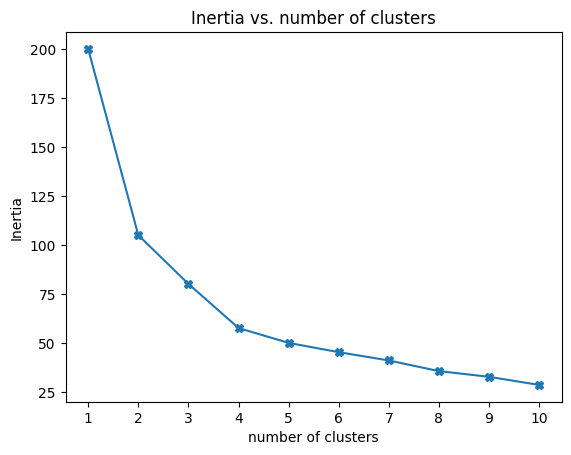

In [48]:
ks = range(1,11)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, n_init=10, random_state=1)
    model.fit(pca_df)
    inertias.append(model.inertia_)
plt.plot(ks, inertias, '-X')
plt.title('Inertia vs. number of clusters')
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

The point after which inertia goes down more gradually, is in fact 2. The biggest drop in iertia is between 1 and 2 clusters. Repeat the model with 2 clusters.

In [49]:
K_model_2 = KMeans(n_clusters=2, n_init=10, random_state=1)
K_model_2.fit(cluster_df)
K_clusters_2 = K_model_2.predict(cluster_df)

Calculate the silhouette score and colour the data points:

In [50]:
s_score_3 = round(silhouette_score(cluster_df, K_clusters_2), 2)

Text(0, 0.5, 'PC1')

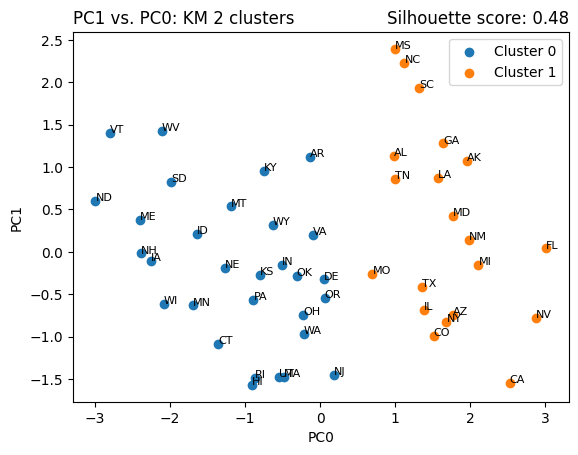

In [51]:
for cluster in range(2):
    plt.scatter(xs[K_clusters_2 == cluster], ys[K_clusters_2 == cluster], label = 'Cluster {}'.format(cluster))
plt.legend()
for i in range(len(short_names)):
    x_coord = xs[i]
    y_coord = ys[i]
    short_name = short_names[i]
    plt.annotate(short_name, (x_coord, y_coord), fontsize=8)
plt.title('PC1 vs. PC0: KM 2 clusters', loc='left')
plt.title('Silhouette score: ' + str(s_score_3), loc='right')
plt.xlabel('PC0')
plt.ylabel('PC1')

The clusters produced this way are identical to the clusters in the agglomerative model. This suggests that this is the optimal way of clustering the data based on the given information. The majority of datapoints can be classified based on their value for PC0, a function of the individual arrest rates and, to a lesser degree, the urban population.